In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F3'
VERSION = 'HARDWARE'
SS_VER = 'SS_VER_1_1'

In [2]:
%run "Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [3]:
%%bash -s "$PLATFORM" "$SS_VER"
cd ../hardware/victims/firmware/masked_dilithium
make PLATFORM=$1 CRYPTO_TARGET=NONE SS_VER=$2

SS_VER set to SS_VER_1_1
make clean_objs .dep 
make[1]: Entering directory '/home/sou/Documents/chipwhisperer-develop/hardware/victims/firmware/masked_dilithium'
SS_VER set to SS_VER_1_1
rm -f -- basic-passwdcheck-CW308_STM32F3.hex
rm -f -- basic-passwdcheck-CW308_STM32F3.eep
rm -f -- basic-passwdcheck-CW308_STM32F3.cof
rm -f -- basic-passwdcheck-CW308_STM32F3.elf
rm -f -- basic-passwdcheck-CW308_STM32F3.map
rm -f -- basic-passwdcheck-CW308_STM32F3.sym
rm -f -- basic-passwdcheck-CW308_STM32F3.lss
rm -f -- objdir-CW308_STM32F3/*.o
rm -f -- objdir-CW308_STM32F3/*.lst
rm -f -- basic-passwdcheck.s rounding.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- basic-passwdcheck.d rounding.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- basic-passwdcheck.i rounding.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
make[1]: '.dep' is up to date.
make[1]: Leaving directory '/home/sou/Documents/chipwhisperer-develop/

basic-passwdcheck.c: In function 'get_pt':
basic-passwdcheck.c:70:18: warning: cast from pointer to integer of different size [-Wpointer-to-int-cast]
   70 |         res[0] = (uint8_t)lowbits_arr;
      |                  ^


In [4]:
scope.default_setup()

In [5]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, "../hardware/victims/firmware/masked_dilithium/basic-passwdcheck-CW308_STM32F3.hex")


Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 16971 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 16971 bytes


In [6]:
#test that the target board is responsive, it should send back a message 'hello'
target.read()

'hello\n'

In [7]:
# Numbre of traces
N = 500

# Numbre of samples per trace
scope.adc.samples = 4000

In [8]:
import matplotlib.pyplot as plt
import os
import numpy as np 
# trace the power consumption when calling the lowbit function with "0" as input 
trace1 =np.zeros((N,scope.adc.samples ))
for i in range(N):
    scope.arm()
    option = bytearray([0]) # Enter a random number to decompose
    target.simpleserial_write('p', option) 

    res = target.simpleserial_read('r',1, timeout=100000)
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace1[i]= scope.get_last_trace()
 
        

In [9]:
import matplotlib.pyplot as plt
import os

# trace the power consumption when calling the lowbit function with non-"0" values as input 

trace2 =np.zeros((N,scope.adc.samples))
for i in range(N):
    scope.arm() 
    option = bytearray([i % 256]) # Enter a random number to decompose
    target.simpleserial_write('p', option) 

    res = target.simpleserial_read('r',1, timeout=100000)
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace2[i]= scope.get_last_trace()
 
        

In [10]:
import pickle

# This is used to store the traces in pickle files

with open('trace1.pickle', 'wb') as f:
    pickle.dump(trace1, f)
    
with open('trace2.pickle', 'wb') as f:
    pickle.dump(trace2, f)

In [11]:
pickle_in = open("trace1.pickle","rb")
trace1 = pickle.load(pickle_in)

In [12]:
pickle_in = open("trace2.pickle","rb")
trace2 = pickle.load(pickle_in)

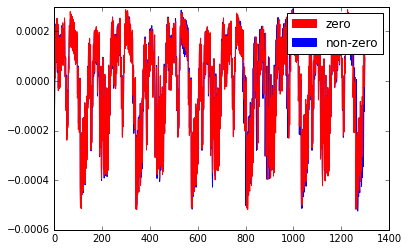

In [17]:
# Compare the average of power consumption for the two cases:
# 1- First case: LowBit(a) with a = 0
# 2- Second case: LowBit(a) with a is NOT 0

PowerConsumptionAverageZERO = np.zeros((scope.adc.samples )) 
PowerConsumptionAverageNONZERO = np.zeros((scope.adc.samples ))


for j in range(scope.adc.samples):
    for i in range(N):
        PowerConsumptionAverageZERO[j] += trace1[i][j]
        PowerConsumptionAverageNONZERO[j] += trace2[i][j]
        
        PowerConsumptionAverageZERO[j] = PowerConsumptionAverageZERO[j]/N  
        PowerConsumptionAverageNONZERO[j] = PowerConsumptionAverageNONZERO[j]/N

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('classic')

%matplotlib inline
plt.figure() 
x = np.linspace(0, 100, 2000)

plt.plot(PowerConsumptionAverageZERO[200:1500], color='blue', label="zero")
plt.plot( PowerConsumptionAverageNONZERO[200:1500], color='red', label="non-zero")

red_patch = mpatches.Patch(color='red', label='zero')
blue_patch = mpatches.Patch(color='blue', label='non-zero')

plt.legend(handles=[red_patch, blue_patch])

plt.show()

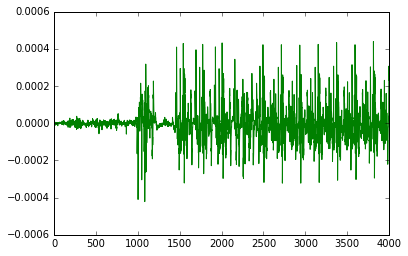

In [18]:
# trace the power consumption when calling the lowbit function with non-"0" values as input 

PowerConsumptionAverageDiff= np.zeros((scope.adc.samples )) 

for i in range(scope.adc.samples): 
    PowerConsumptionAverageDiff[i] = PowerConsumptionAverageZERO[i] -PowerConsumptionAverageNONZERO[i]
%matplotlib inline
plt.figure() 
plt.plot(PowerConsumptionAverageDiff, color='green', label="zero") 

plt.show()


### The code called between the triggers is:
#####	/**********************************
#####	* Start user-specific code here. */ 
#####	trigger_high(); 
####       arith_mask(value,a);
#####	arith_to_bool_lowbits(a,BETA1,lowbits_arr);
#####	for (int j=0;j<10;j++) 		asm("nop");
#####   /* End user-specific code here. *
####	********************************/
        

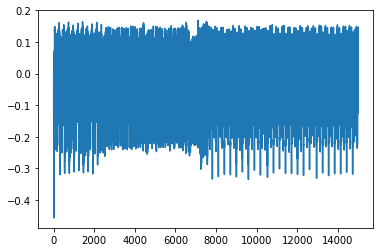

In [10]:
# 10 sahres
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(trace) 
plt.show()

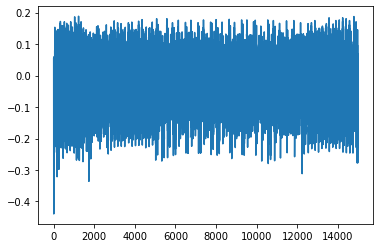

In [10]:
# 1 share
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(trace) 
plt.show()

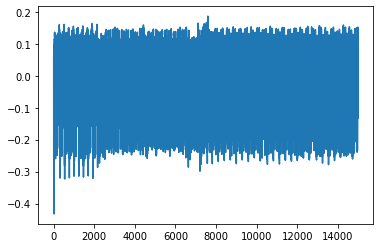

In [10]:
# 10 shares with the sharing ( calling the function arith_mask(value,a))
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(trace) 
plt.show()

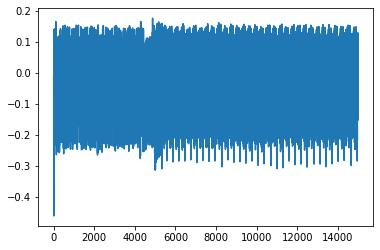

In [32]:
# 10 shares without the sharing ( calling the function arith_mask(value,a))
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(trace) 
plt.show()

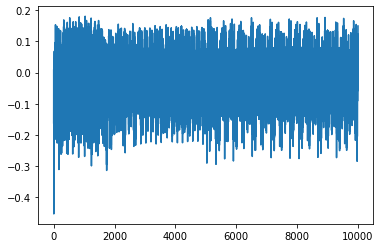

In [15]:
# 1 shares
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(trace) 
plt.show()

## Examples

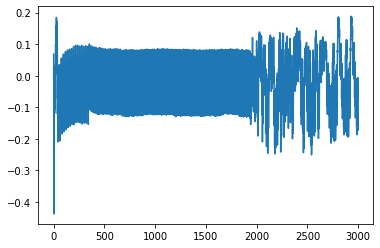

In [10]:
#running 100 loop asm("nop")
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(trace) 
plt.show()

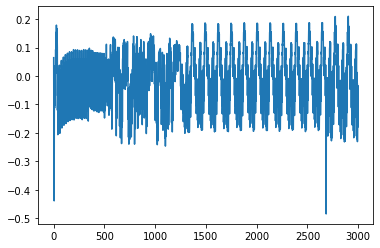

In [47]:
#running 10 loop asm("nop")
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(trace) 
plt.show()

In [11]:
scope.dis()
target.dis()